In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import requests
import torchvision
import sys
torchvision.disable_beta_transforms_warning()

from PIL import Image
import torchvision.transforms.v2 as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
from torchinfo import summary
from tqdm import tqdm
from torchmetrics.classification import MulticlassAccuracy
from sklearn.metrics import accuracy_score

In [2]:
torch.__version__

'2.0.1'

In [3]:
def crop_save_image(row, folder_name:str = 'train'):
    img2 = Image.open(
        os.path.join(os.getcwd(), 'flickr_logos_27_dataset_images', row['file_name'])).crop(
        (row['x1'], row['y1'], row['x2'], row['y2'])
    )
    path = os.path.join(os.getcwd(), folder_name, row['label'], row['file_name'])
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    try:
        img2.save(path)
    except:
        os.mkdir(os.path.join(folder_name, row['label']))
    return os.path.join(folder_name, row['file_name'])

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
torch.set_default_device(device)

In [6]:
def train_step(model: nn.Module, data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        y_pred = model(X)
        loss = loss_fn(y_pred, y)        
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)    
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f}%")
    return train_acc
def test_step(data_loader: torch.utils.data.DataLoader,
              model: nn.Module, loss_fn: nn.Module,
              accuracy_fn):
    test_loss, test_acc = 0, 0
    #model.eval()
    with torch.inference_mode():         
        for X, y in data_loader:
            test_pred = model(X)     
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)        
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%\n")
    return test_acc

In [7]:
def get_predicted_class(row, class_dict:dict, model:nn.Module, trf):
    with torch.inference_mode():
        im_path = os.path.join('flickr_logos_27_dataset_images', row['file_name'])
        if os.path.isfile(im_path):
            img = trf(Image.open(im_path))
            cls = model(img.unsqueeze(0))
            return class_dict[np.argmax(np.array(cls.cpu()))]
        else:
            return np.nan

In [8]:
if device == 'cuda':
    torch.cuda.empty_cache()

In [9]:
train_img_labels_file = os.path.join(os.getcwd(),
                                    "flickr_logos_27_dataset_training_set_annotation.txt")

train_images = pd.read_csv(train_img_labels_file,
                           sep=' ', 
                           usecols = [i for i in range(7)],
                           header=None,  
                           names=["file_name",'label','subset','x1','y1','x2','y2'])
train_images.head()

,file_name,label,subset,x1,y1,x2,y2
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


In [10]:
len(train_images)

4536

In [11]:
test_img_label_file = os.path.join(os.getcwd(),
                                    "flickr_logos_27_dataset_query_set_annotation.txt")

test_images = pd.read_csv(test_img_label_file,
                           sep='\t', 
                            usecols = [i for i in range(2)],
                           header=None,  
                           names=["file_name",'label'])
test_images

,file_name,label
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas
...,...,...
265,3480640208.jpg,none
266,3486224308.jpg,none
267,3486430785.jpg,none
268,3490185235.jpg,none


In [12]:
len(test_images)

270

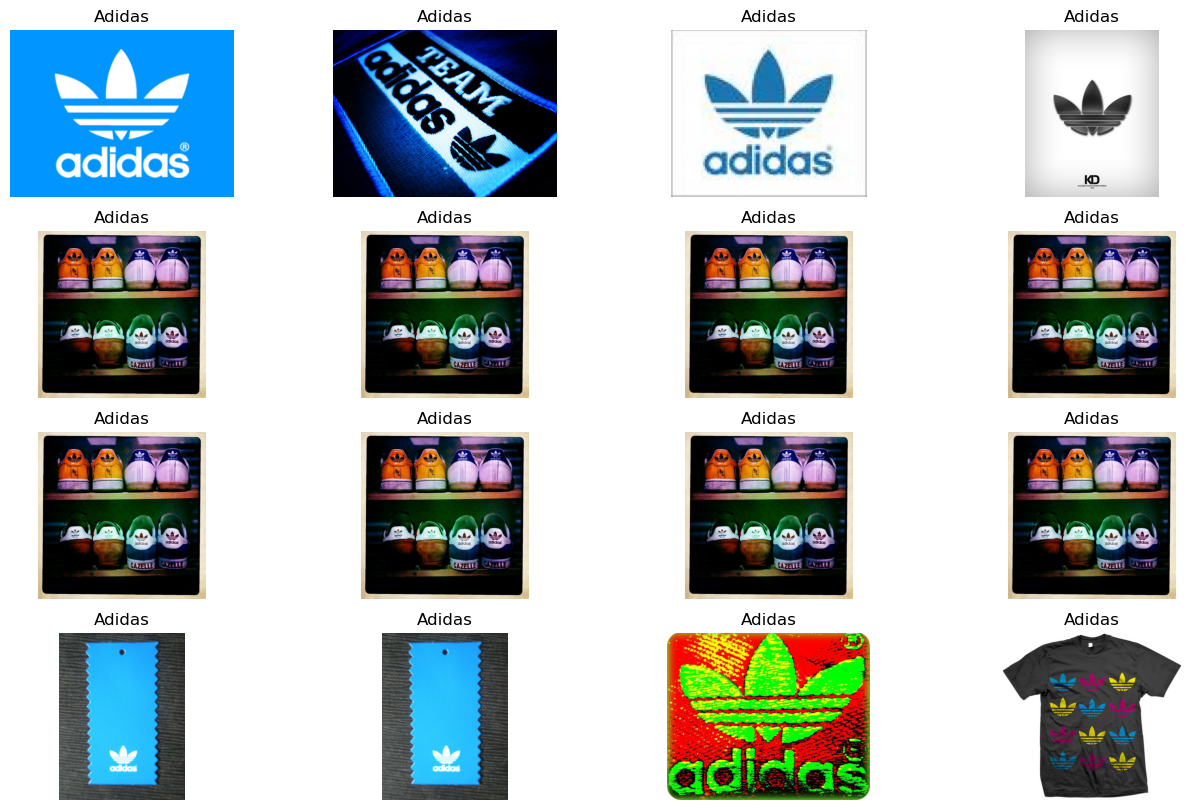

In [13]:
# Training images
plt.figure(figsize=(16, 10))
for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(Image.open('flickr_logos_27_dataset_images/'+ train_images.loc[idx,'file_name']))
    plt.title(train_images.loc[idx,'label'])
    plt.axis("off")

In [14]:
diff = set(train_images['label'].unique()).symmetric_difference(set(test_images['label'].unique()))

In [15]:
#Remove any unrepresented labels
train_images = train_images[train_images['label'].isin(diff) == False]
test_images = test_images[test_images['label'].isin(diff) == False]

In [16]:
#Subset? There is no apparent use for this column
train_images.drop(columns='subset', inplace=True)

In [17]:
#Why so many duplicate images?
train_images.drop_duplicates(['file_name'], inplace=True)

In [18]:
train_images['delta_x'] = train_images['x2'] - train_images['x1']

In [19]:
train_images['delta_y'] = train_images['y2'] - train_images['y1']

In [20]:
train_images = train_images.drop(
    index = train_images[(train_images['delta_x']<=0) | (train_images['delta_y']<=0)].index)

In [21]:
train_images

,file_name,label,x1,y1,x2,y2,delta_x,delta_y
0,144503924.jpg,Adidas,38,12,234,142,196,130
1,2451569770.jpg,Adidas,242,208,413,331,171,123
2,390321909.jpg,Adidas,13,5,89,60,76,55
3,4761260517.jpg,Adidas,43,122,358,354,315,232
4,4763210295.jpg,Adidas,83,63,130,93,47,30
...,...,...,...,...,...,...,...,...
4498,2168708196.jpg,Yahoo,4,4,232,62,228,58
4499,2990076322.jpg,Yahoo,40,310,281,361,241,51
4506,3469867139.jpg,Yahoo,108,175,178,201,70,26
4508,3992886999.jpg,Yahoo,80,194,170,243,90,49


In [22]:
#Seems like there are no multiple labels on the same pic
all(train_images.groupby('file_name')[['x1', 'y1', 'x2', 'y2']].mean().apply(lambda x:round(x, 0))
    == train_images.groupby('file_name')[['x1', 'y1', 'x2', 'y2']].mean())

True

In [23]:
#No duplicates in test
test_images = test_images.drop_duplicates(['file_name'])

In [24]:
test_images

,file_name,label
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas
...,...,...
130,3040021292.jpg,Nbc
131,319239030.jpg,Nbc
132,3386938907.jpg,Nbc
133,3815108969.jpg,Nbc


In [25]:
train_images['train_path'] = train_images.apply(lambda row: crop_save_image(row, folder_name='train'), axis=1)

In [26]:
train_images

,file_name,label,x1,y1,x2,y2,delta_x,delta_y,train_path
0,144503924.jpg,Adidas,38,12,234,142,196,130,train/144503924.jpg
1,2451569770.jpg,Adidas,242,208,413,331,171,123,train/2451569770.jpg
2,390321909.jpg,Adidas,13,5,89,60,76,55,train/390321909.jpg
3,4761260517.jpg,Adidas,43,122,358,354,315,232,train/4761260517.jpg
4,4763210295.jpg,Adidas,83,63,130,93,47,30,train/4763210295.jpg
...,...,...,...,...,...,...,...,...,...
4498,2168708196.jpg,Yahoo,4,4,232,62,228,58,train/2168708196.jpg
4499,2990076322.jpg,Yahoo,40,310,281,361,241,51,train/2990076322.jpg
4506,3469867139.jpg,Yahoo,108,175,178,201,70,26,train/3469867139.jpg
4508,3992886999.jpg,Yahoo,80,194,170,243,90,49,train/3992886999.jpg


In [27]:
#Can be set to max or mean
width, height = round(train_images[['delta_x', 'delta_y']].mean())

In [28]:
width, height = int(width), int(height)

In [47]:
width, height

(500, 495)

In [29]:
#Using v2 transforms is faster and 
train_data_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((width, height), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(3),
    #transforms.RandomRotation(30),
    transforms.TrivialAugmentWide(num_magnitude_bins=11),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
test_data_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((width, height), antialias=True),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [30]:
train_set_aug = datasets.ImageFolder(root='train', transform=train_data_transform)
test_set = datasets.ImageFolder(root='train', transform=test_data_transform, target_transform=None)

In [31]:
class_names = train_set_aug.classes
class_dict = train_set_aug.class_to_idx

In [32]:
class_dict

{'Adidas': 0,
 'Apple': 1,
 'BMW': 2,
 'Citroen': 3,
 'Cocacola': 4,
 'DHL': 5,
 'Fedex': 6,
 'Ferrari': 7,
 'Ford': 8,
 'Google': 9,
 'HP': 10,
 'Heineken': 11,
 'Intel': 12,
 'McDonalds': 13,
 'Mini': 14,
 'Nbc': 15,
 'Nike': 16,
 'Pepsi': 17,
 'Porsche': 18,
 'Puma': 19,
 'RedBull': 20,
 'Sprite': 21,
 'Starbucks': 22,
 'Texaco': 23,
 'Unicef': 24,
 'Vodafone': 25,
 'Yahoo': 26}

In [33]:
class_dict_inv = {v: k for k, v in class_dict.items()}

In [34]:
BATCH_SIZE=32

In [35]:
train_dataloader = DataLoader(dataset=train_set_aug, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator(device='cuda'),)
test_dataloader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, generator=torch.Generator(device='cuda'),)

In [36]:
next(iter(train_dataloader))[0].cpu().shape

torch.Size([32, 3, 500, 495])

In [37]:
NUM_CLASSES = len(class_dict)

In [38]:
NUM_EPOCHS = 40

In [39]:
#Use if model has been changed
REWRITE_MODEL=True

In [40]:
class ClModel(nn.Module):
    def __init__(self, input_shape=3, hidden_layers=30, output_shape = 3):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Conv2d(input_shape, hidden_layers, kernel_size = 3, stride = 1, padding=1),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(hidden_layers, hidden_layers, kernel_size = 3, stride = 1, padding=1),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=93600, out_features=500),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=output_shape),
            nn.LogSoftmax(dim=1),
            )
    def forward(self, x):
        return self.sequential_model(x)
    
model = ClModel(input_shape = 3, hidden_layers=50, output_shape=NUM_CLASSES)

if os.path.isfile('model.pth') and REWRITE_MODEL==False:
    model.load_state_dict(torch.load('model.pth'))

In [41]:
torch.compile(model)

OptimizedModule(
  (_orig_mod): ClModel(
    (sequential_model): Sequential(
      (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GELU(approximate='none')
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=93600, out_features=500, bias=True)
      (8): Dropout(p=0.3, inplace=False)
      (9): ReLU()
      (10): Linear(in_features=500, out_features=27, bias=True)
      (11): LogSoftmax(dim=1)
    )
  )
)

In [42]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=1e-5, amsgrad=True)

In [43]:
accuracy_fn = MulticlassAccuracy(len(class_names))

In [44]:
val_data_transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((width, height), antialias=True),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [46]:
if not os.path.isfile('model.pth') or REWRITE_MODEL == True:
    for epoch in tqdm(range(NUM_EPOCHS)):
        train_acc = train_step(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn
            )
        test_acc = test_step(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn
            )
        test_images['pred_label'] = test_images.apply(
            lambda row: get_predicted_class(row, class_dict=class_dict_inv, model=model, trf=val_data_transform),
            axis=1)
        real_acc = accuracy_score(test_images['label'], test_images['pred_label'])
        print(f'Real accuracy: {real_acc:.2f}')
    torch.save(model.state_dict(), os.path.join(os.getcwd(), 'model.pth'))

  0%|          | 0/40 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 378.00 MiB (GPU 0; 11.71 GiB total capacity; 9.85 GiB already allocated; 182.44 MiB free; 9.88 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF